# MuhRec in python demonstration

In [62]:
import sys, os
sys.path.insert(0, "/Users/kaestner/git/imagingsuite/frameworks/install/lib")
sys.path.insert(0, "/Users/kaestner/git/scripts/python/")
if 'LD_LIBRARY_PATH' not in os.environ:
    os.environ['LD_LIBRARY_PATH'] = '/Users/kaestner/git/imagingsuite/frameworks/install/lib'
   # os.execv(sys.argv[0], sys.argv)




In [63]:
import numpy as np
import muhrectomo as mt
import matplotlib.pyplot as plt
import amglib.readers as io
import amglib.imageutils as amg

In [64]:
import importlib
importlib.reload(mt)
importlib.reload(io)
importlib.reload(amg)

<module 'amglib.imageutils' from '/Users/kaestner/git/scripts/python/amglib/imageutils.py'>

## Create a reconstructor object

In [65]:
recon = mt.Reconstructor(mt.bpMultiProj)

print("Created reconstructor :",recon.name())

Created reconstructor : Multi projection BP


## Reconstruction workflow

### Numerical dummy
This dummy is only to test the connection and that the reconstructor starts at all. Only nonsense data.

In [66]:
Nproj = 10
proj = np.ones([Nproj,256,256])

In [67]:
args = {"angles" : np.linspace(0,180,num=Nproj), 
        "weights" : np.ones(Nproj)}

In [68]:
recon.configure({   "center" : 50, 
                    "resolution" : 0.135
                })

In [69]:
recon.process(proj,args)

vol = recon.volume()

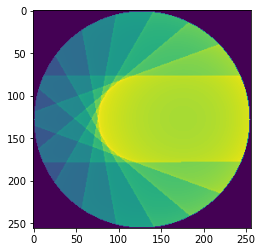

In [70]:
plt.imshow(vol[0])

### The wood data
The wood data is the data I use a lot for demos, tests, and tutorials. It a piece of petrified wood [DOI](http://dx.doi.org/10.17632/g5snr785xy.2). 

#### Load projection data

In [71]:
ob = io.readImages('/Users/Shared/data/wooddata/projections/ob_{0:04d}.tif',1,5,averageStack=True).mean(axis=0)
dc = io.readImages('/Users/Shared//data/wooddata/projections/dc_{0:04d}.tif',1,5,averageStack=True).mean(axis=0)

100%|██████████| 4/4 [00:00<00:00, 33.40it/s]


In [72]:
proj = io.readImages('/Users/Shared/data/wooddata/projections/wood_{0:04d}.tif',1,626) # This takes a while

100%|██████████| 625/625 [00:09<00:00, 62.76it/s] 


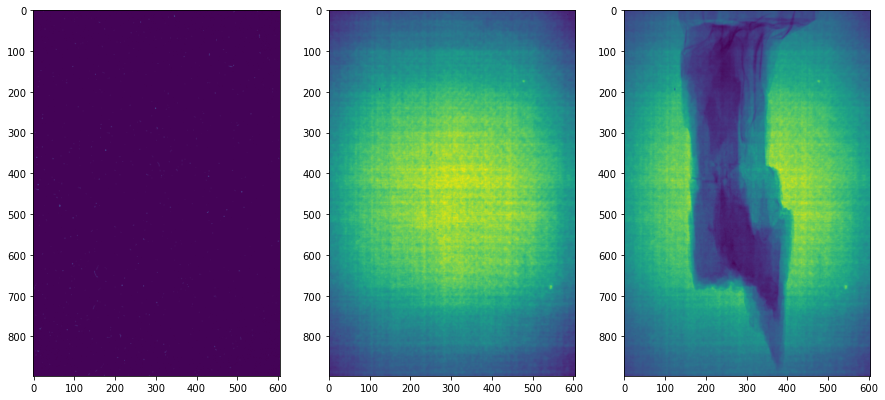

In [73]:
fig,ax = plt.subplots(1,3,figsize=[15,7])
ax[0].imshow(dc)
ax[1].imshow(ob)
ax[2].imshow(proj[0])


## Preprocessing
Here the projections needs to be prepared for reconstruction. Typical operations are 
- Cropping
- Normalization (possibly with scattering correction)
- Spot cleaning
- Ring cleaning

### Normalize - the kipl way

In [74]:
import imgalg 

In [75]:
norm = imgalg.NormalizeImage(True) # True for use logarithm

In [76]:
norm.usingLog()

True

In [77]:
norm = imgalg.NormalizeImage(True) # True for use logarithm
norm.setReferences(ob,dc)
cproj = proj.copy()
norm.process(cproj)

## Normalize - the python way

In [78]:
nproj = amg.normalizeImage(img=proj, ob=ob, dc=dc, neglog=True)

100%|██████████| 626/626 [00:02<00:00, 224.77it/s]


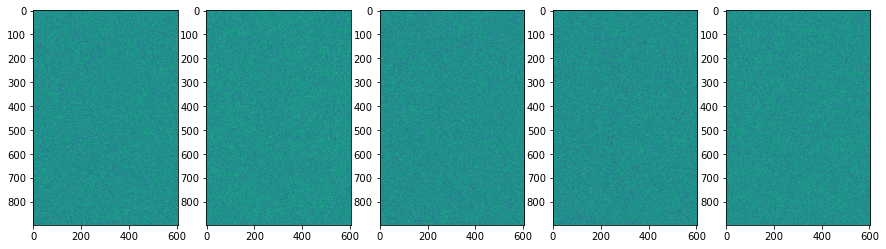

In [79]:
fig,axes=plt.subplots(1,5,figsize=(15,4))

for idx,ax in enumerate(axes) :
    ax.imshow(cproj[idx*20]-nproj[idx*20])

In [80]:
print(nproj.shape,cproj.shape)

(626, 897, 604) (626, 897, 604)


(626, 897, 604)

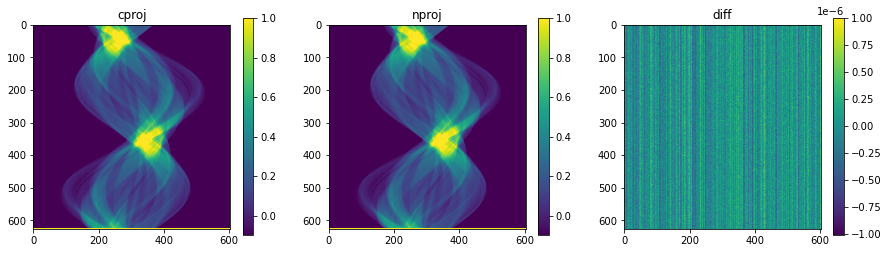

In [81]:
fig,axes=plt.subplots(1,3,figsize=(15,4))
a0=axes[0].imshow(cproj[:,400,:], vmin=-0.1,vmax=1); axes[0].set_title('cproj')
fig.colorbar(a0,ax=axes[0])
a1=axes[1].imshow(nproj[:,400,:], vmin=-0.1,vmax=1); axes[1].set_title('nproj')
fig.colorbar(a1,ax=axes[1])
a2=axes[2].imshow(cproj[:,400,:]-nproj[:,400,:]); axes[2].set_title('diff')
fig.colorbar(a2,ax=axes[2])

cproj.shape

#### Prepare and run the back-projection

In [82]:
Nproj = cproj.shape[0]
# Information per projection
args = {"angles"  : np.linspace(0,360,num=Nproj), 
        "weights" : np.ones(Nproj)/Nproj
       }

# Geometry information
recon.configure({   "center" : 305, 
                    "resolution" : 0.1
                })
print("have",Nproj,"projections")

have 626 projections


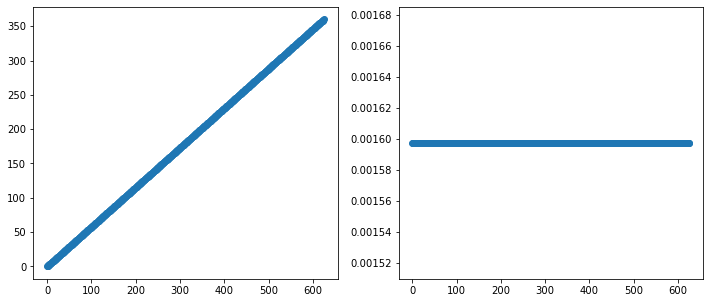

In [83]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(args["angles"],'o')
ax[1].plot(args["weights"],'o')

In [84]:
recon.process(cproj[:,500:510,:],args) # Reconstruct a part of the slices (32 slices here)
del vol
vol = recon.volume() # Retrieve the reconstructed volume

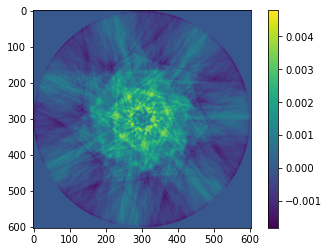

In [85]:
plt.imshow(vol[0])
plt.colorbar()
plt.savefig('recon.png',dpi=300)

In [34]:
import ipyvolume as ipv

In [35]:
ipv.widgets.quickvolshow(vol)

/Users/kaestner/opt/anaconda3/lib/python3.8/site-packages/ipyvolume/widgets.py:241: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_view = self.data_original[view]
/Users/kaestner/opt/anaconda3/lib/python3.8/site-packages/ipyvolume/utils.py:207: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = (data[slices1] + data[slices2]) / 2
/Users/kaestner/opt/anaconda3/lib/python3.8/site-packages/ipyvolume/serialize.py:92: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0] ** 2 + gradient[1] *

In [61]:
print(nproj.flags)
print(cproj.flags)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



In [25]:
a=cproj[:,500:510,:]
b=nproj[:,500:510,:]

# Spotcleaning tests

In [86]:
msc = imgalg.MorphSpotClean()

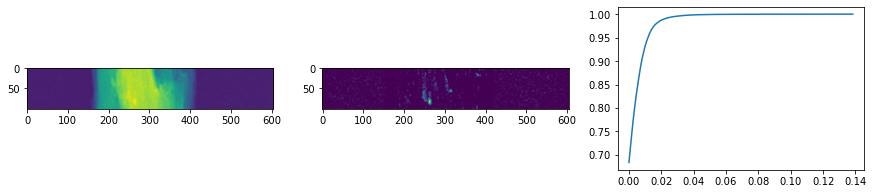

In [111]:
strip= cproj[1,500:600,:]
msc.setCleanMethod(detectionMethod=imgalg.MorphDetectPeaks, cleanMethod=imgalg.MorphCleanReplace);
d=msc.detectionImage(strip)
fig, ax = plt.subplots(1,3,figsize=(15,3))
ax[0].imshow(strip)
ax[1].imshow(d)
phist,pbins=np.histogram(d.ravel(), bins=500)
ax[2].plot(bins[:-1],np.cumsum(hist)/hist.sum())

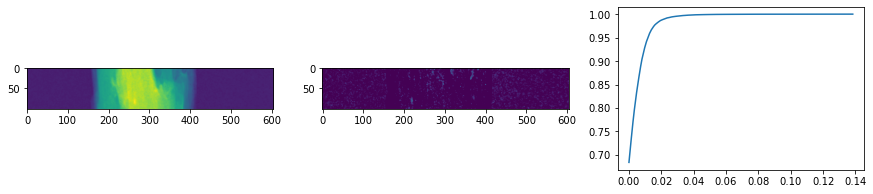

In [109]:
strip= cproj[1,500:600,:]
msc.setCleanMethod(detectionMethod=imgalg.MorphDetectHoles, cleanMethod=imgalg.MorphCleanReplace);
dh=msc.detectionImage(strip)
fig, ax = plt.subplots(1,3,figsize=(15,3))
ax[0].imshow(strip)
ax[1].imshow(dh)
hhist,hbins=np.histogram(dh.ravel(), bins=500)
ax[2].plot(bins[:-1],np.cumsum(hhist)/hhist.sum())

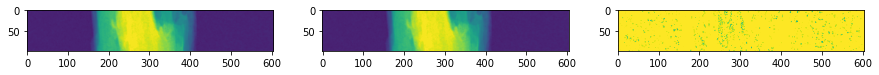

In [116]:
strip= cproj[1,500:600,:].copy()
orig = cproj[1,500:600,:]
msc.process(strip,th=[0.02, 0.02],sigma=[0.001, 0.001])
fig, ax = plt.subplots(1,3,figsize=(15,3))
ax[0].imshow(orig)
ax[1].imshow(strip)
ax[2].imshow(strip-orig)